# DX 704 Week 4 Project

This week's project will test the learning speed of linear contextual bandits compared to unoptimized approaches.
You will start with building a preference data set for evaluation, and then implement different variations of LinUCB and visualize how fast they learn the preferences.


The full project description, a template notebook and supporting code are available on GitHub: [Project 4 Materials](https://github.com/bu-cds-dx704/dx704-project-04).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Collect Rating Data

The file "recipes.tsv" in this repository has information about 100 recipes.
Make a new file "ratings.tsv" with two columns, recipe_slug (from recipes.tsv) and rating.
Populate the rating column with values between 0 and 1 where 0 is the worst and 1 is the best.
You can assign these ratings however you want within that range, but try to make it reflect a consistent set of preferences.
These could be your preferences, or a persona of your choosing (e.g. chocolate lover, bacon-obsessed, or sweet tooth).
Make sure that there are at least 10 ratings of zero and at least 10 ratings of one.


Hint: You may find it more convenient to assign raw ratings from 1 to 5 and then remap them as follows.

`ratings["rating"] = (ratings["rating_raw"] - 1) * 0.25`

In [7]:
import pandas as pd
import numpy as np
import hashlib
from pathlib import Path

RECIPES_PATH = Path("recipes.tsv")  
OUTPUT_PATH  = Path("ratings.tsv")

# Vegetarian, spicy-leaning persona:
LIKE_KEYWORDS = ["chili","curry","tofu","lentil","mushroom","broccoli","spicy","garlic","ginger"]
DISLIKE_KEYWORDS = ["bacon","pork","beef","sausage","ham","steak","fried","butter","cream","sugar"]

In [8]:
def deterministic_noise(s: str, scale: float = 0.2) -> float:
    """Deterministic small noise for tie-breaking, in range [-scale, scale]."""
    h = hashlib.md5(s.encode("utf-8")).hexdigest()
    u = int(h[:8], 16) / 0xFFFFFFFF
    return (u * 2 - 1) * scale

def count_hits(text_series: pd.Series, keywords: list[str]) -> np.ndarray:
    pat = "|".join([rf"\b{kw.replace('_','[ _-]')}\b" for kw in keywords])
    return text_series.str.count(pat).fillna(0).to_numpy()

In [9]:
recipes = pd.read_csv(RECIPES_PATH, sep="\t")
if "recipe_slug" not in recipes.columns:
    raise ValueError("recipes.tsv must contain a 'recipe_slug' column.")

text_cols = [c for c in ["title","ingredients","recipe_slug"] if c in recipes.columns]
text = recipes[text_cols].astype(str).agg(" ".join, axis=1).str.lower()

like_hits = count_hits(text, LIKE_KEYWORDS)
dis_hits  = count_hits(text, DISLIKE_KEYWORDS)

# Raw rating 1–5, then remap to [0,1]
raw = 3 + like_hits - dis_hits + np.array([deterministic_noise(s, 0.3) for s in recipes["recipe_slug"].astype(str)])
raw = np.clip(np.round(raw), 1, 5)  # keep within 1–5 integers
ratings = pd.DataFrame({
    "recipe_slug": recipes["recipe_slug"],
    "rating_raw": raw.astype(int)
})
ratings["rating"] = (ratings["rating_raw"] - 1) * 0.25

# Ensure ≥10 zeros and ones
ratings_sorted = ratings.sort_values("rating")
if (ratings_sorted["rating"] == 0).sum() < 10:
    ratings_sorted.iloc[:10, ratings_sorted.columns.get_loc("rating_raw")] = 1
    ratings_sorted["rating"] = (ratings_sorted["rating_raw"] - 1) * 0.25

ratings_sorted = ratings_sorted.sort_values("rating", ascending=False)
if (ratings_sorted["rating"] == 1).sum() < 10:
    ratings_sorted.iloc[:10, ratings_sorted.columns.get_loc("rating_raw")] = 5
    ratings_sorted["rating"] = (ratings_sorted["rating_raw"] - 1) * 0.25

# Finalize
ratings_final = ratings_sorted.sort_values("recipe_slug").reset_index(drop=True)
ratings_final[["recipe_slug","rating"]].to_csv(OUTPUT_PATH, sep="\t", index=False)

print(f"Wrote {len(ratings_final)} ratings to {OUTPUT_PATH}")
print("Counts:", ratings_final["rating"].value_counts().to_dict())
ratings_final.head()

Wrote 100 ratings to ratings.tsv
Counts: {0.5: 70, 0.25: 10, 0.0: 10, 1.0: 10}


,recipe_slug,rating_raw,rating
0,almond-chip-cookies,3,0.5
1,almond-croissants,3,0.5
2,apple-crisp,3,0.5
3,apple-crumble,3,0.5
4,apple-pie,3,0.5


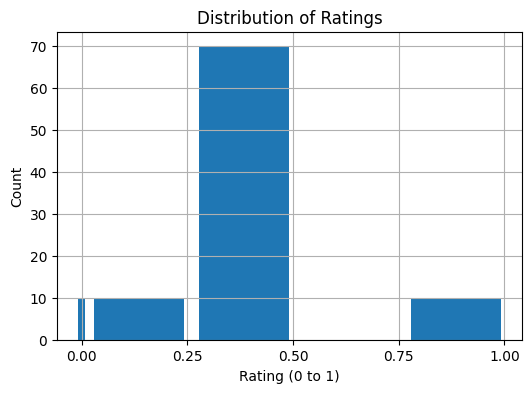

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
ratings_final["rating"].hist(bins=[-0.01,0.01,0.26,0.51,0.76,1.01], rwidth=0.85)
plt.xticks([0,0.25,0.5,0.75,1.0])
plt.xlabel("Rating (0 to 1)")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

Submit "ratings.tsv" in Gradescope.

## Part 2: Construct Model Input

Use your file "ratings.tsv" combined with "recipe-tags.tsv" to create a new file "features.tsv" with a column recipe_slug, a column bias which is hard-coded to one, and a column for each tag that appears in "recipe-tags.tsv".
The tag column in this file should be a 0-1 encoding of the recipe tags for each recipe.
[Pandas reshaping function methods](https://pandas.pydata.org/docs/user_guide/reshaping.html) may be helpful.

The bias column will make later LinUCB calculations easier since it will just be another dimension.

Hint: For later modeling steps, it will be important to have the feature data (inputs) and the rating data (target outputs) in the same order.
It is highly recommended to make sure that "features.tsv" and "ratings.tsv" have the recipe slugs in the same order.

In [13]:
# YOUR CHANGES HERE

RATINGS_PATH = Path("ratings.tsv")
TAGS_PATH    = Path("recipe-tags.tsv")
OUT_PATH     = Path("features.tsv")

ratings = pd.read_csv(RATINGS_PATH, sep="\t")
if "recipe_slug" not in ratings.columns:
    raise ValueError("ratings.tsv must contain a 'recipe_slug' column.")
if "rating" not in ratings.columns:
    raise ValueError("ratings.tsv must contain a 'rating' column.")

tags_df = pd.read_csv(TAGS_PATH, sep="\t")

In [14]:
def to_long(df):
    cols = [c.lower() for c in df.columns]
    lower_map = {c: c.lower() for c in df.columns}
    df_ = df.rename(columns=lower_map)
    if "recipe_slug" not in df_.columns:
        raise ValueError("recipe-tags.tsv must contain a 'recipe_slug' column.")
    
    if "tag" in df_.columns:
        # Already long format
        out = df_[["recipe_slug","tag"]].dropna()
        out["tag"] = out["tag"].astype(str).str.strip()
        out = out[out["tag"]!=""]
        return out
    
    if "tags" in df_.columns:
        # Split delimited list into long format
        # Accept comma/pipe/semicolon/space as delimiters
        tmp = df_[["recipe_slug","tags"]].copy()
        tmp["tags"] = tmp["tags"].fillna("").astype(str)
        # Replace multiple common delimiters with a single comma for splitting
        repl = {
            "|": ",", ";": ",", "/": ",", "\\": ","
        }
        s = tmp["tags"]
        for k,v in repl.items():
            s = s.str.replace(k, v, regex=False)
        # Also normalize spaces around commas
        s = s.str.replace(r"\s*,\s*", ",", regex=True)
        # Finally split on comma; if no comma, split on whitespace fallback
        # Build long frame
        rows = []
        for slug, taglist in zip(tmp["recipe_slug"], s):
            if taglist.strip() == "":
                continue
            parts = [t.strip() for t in taglist.split(",") if t.strip()!=""]
            if len(parts) == 1 and " " in parts[0] and "," not in taglist:
                parts = [t for t in parts[0].split() if t]
            for t in parts:
                rows.append((slug, t))
        out = pd.DataFrame(rows, columns=["recipe_slug","tag"])
        return out
    
    # If neither 'tag' nor 'tags' exists, try to guess a reasonable tag column
    other_cols = [c for c in df_.columns if c!="recipe_slug"]
    if len(other_cols)==1:
        guessed = other_cols[0]
        out = df_[["recipe_slug", guessed]].rename(columns={guessed:"tag"}).dropna()
        out["tag"] = out["tag"].astype(str).str.strip()
        out = out[out["tag"]!=""]
        return out
    
    raise ValueError(
        "recipe-tags.tsv must contain either a 'tag' column (long format) or a 'tags' column (list format)."
    )

tags_long = to_long(tags_df)

In [15]:
# Clean tag strings: lowercase, replace spaces and special chars with underscores
def clean_tag(t: str) -> str:
    t = str(t).strip().lower()
    # Replace spaces and common punctuation with underscores
    t = t.replace("&"," and ")
    t = t.replace("+"," plus ")
    t = t.replace("/"," ")
    t = t.replace("\\"," ")
    t = t.replace("-", " ")
    t = " ".join(t.split())  # collapse whitespace
    t = t.replace(" ", "_")
    return t

tags_long["tag"] = tags_long["tag"].map(clean_tag)
tags_long = tags_long[tags_long["tag"]!=""]


In [16]:
# Deduplicate in case of duplicate entries
tags_long = tags_long.drop_duplicates(["recipe_slug","tag"])
one_hot = (
    tags_long.assign(val=1)
             .pivot(index="recipe_slug", columns="tag", values="val")
             .fillna(0)
             .astype(int)
)

In [17]:
one_hot.insert(0, "bias", 1)

# Left join on recipe_slug using ratings as the key order
features = ratings[["recipe_slug"]].merge(one_hot, on="recipe_slug", how="left")

# Fill missing tags with 0 for recipes that had no tags in the file
tag_cols = [c for c in features.columns if c not in ["recipe_slug"]]
features[tag_cols] = features[tag_cols].fillna(0).astype(int)

In [18]:
# Ensure column ordering: recipe_slug, bias, then tags (sorted for reproducibility)
ordered_cols = ["recipe_slug", "bias"] + sorted([c for c in features.columns if c not in ["recipe_slug","bias"]])
features = features[ordered_cols]

features.to_csv(OUT_PATH, sep="\t", index=False)
print(f"Wrote features with shape {features.shape} to {OUT_PATH}")
print("First 5 rows:")
display(features.head())

Wrote features with shape (100, 298) to features.tsv
First 5 rows:


,recipe_slug,bias,alfredo,almond,american,appetizer,appetizers,apple,asiancuisine,asparagus,...,udonnoodles,vanilla,vanillaicecream,vegan,vegetables,vegetarian,warm,whippedcream,winter,yeastdough
0,almond-chip-cookies,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,almond-croissants,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,apple-crisp,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,apple-crumble,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
4,apple-pie,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Submit "features.tsv" in Gradescope.

## Part 3: Linear Preference Model

Use your feature and rating files to build a ridge regression model with ridge regression's regularization parameter $\alpha$ set to 1.


Hint: If you are using scikit-learn modeling classes, you should use `fit_intercept=False` since that intercept value will be redundant with the bias coefficient.

Hint: The estimate component of the bounds should match the previous estimate, so you should be able to just focus on the variance component of the bounds now.

In [19]:
# YOUR CHANGES HERE

from sklearn.linear_model import Ridge

FEATURES_PATH = Path("features.tsv")
RATINGS_PATH  = Path("ratings.tsv")
MODEL_PATH    = Path("model.tsv")


features = pd.read_csv(FEATURES_PATH, sep="\t")
ratings  = pd.read_csv(RATINGS_PATH,  sep="\t")

In [20]:
# If already aligned, this merge preserves order; if not, it realigns to ratings order.
X = ratings[["recipe_slug"]].merge(features, on="recipe_slug", how="left")
if X.isna().any().any():
    # If any recipe from ratings has no feature row, fill tag columns with 0, keep bias if present
    tag_cols = [c for c in X.columns if c not in ["recipe_slug"]]
    X[tag_cols] = X[tag_cols].fillna(0)

# Separate design matrix and target
tag_cols = [c for c in X.columns if c != "recipe_slug"]
if "bias" not in tag_cols:
    raise ValueError("features.tsv must include a 'bias' column of 1s (added in Part 2).")

y = ratings["rating"].astype(float).to_numpy()
X_mat = X[tag_cols].to_numpy(dtype=float)

In [ ]:
model = Ridge(alpha=1.0, fit_intercept=False) 
model.fit(X_mat, y)

# Optional sanity metrics
r2   = model.score(X_mat, y)
mse  = float(np.mean((model.predict(X_mat) - y)**2))
print(f"Fitted Ridge (alpha=1, no intercept). R^2={r2:.4f}, MSE={mse:.6f}")

Fitted Ridge (alpha=1, no intercept). R^2=0.9539, MSE=0.002563


Save the coefficients of this model in a file "model.tsv" with columns "recipe_tag" and "coefficient".
Do not add anything for the `intercept_` attribute of a scikit-learn model; this will be covered by the coefficient for the bias column added in part 2.

In [24]:
# YOUR CHANGES HERE

coefs = pd.DataFrame({
    "recipe_tag": tag_cols,
    "coefficient": model.coef_.astype(float)
}).sort_values("recipe_tag").reset_index(drop=True)

coefs.to_csv(MODEL_PATH, sep="\t", index=False)
print(f"Wrote {len(coefs)} coefficients to {MODEL_PATH}")
coefs.head()

Wrote 297 coefficients to model.tsv


,recipe_tag,coefficient
0,alfredo,-0.003009
1,almond,0.065075
2,american,0.014976
3,appetizer,-0.026786
4,appetizers,0.029134


Submit "model.tsv" in Gradescope.

## Part 4: Recipe Estimates

Use the recipe model to estimate the score of every recipe.
Save these estimates to a file "estimates.tsv" with columns recipe_slug and score_estimate.

In [ ]:
# YOUR CHANGES HERE

FEATURES_PATH  = Path("features.tsv")
MODEL_PATH     = Path("model.tsv")
RATINGS_PATH   = Path("ratings.tsv") 
ESTIMATES_PATH = Path("estimates.tsv")

features = pd.read_csv(FEATURES_PATH, sep="\t")
coefs_df = pd.read_csv(MODEL_PATH, sep="\t")

tag_cols = [c for c in features.columns if c != "recipe_slug"]
coef_map = dict(zip(coefs_df["recipe_tag"], coefs_df["coefficient"]))

# Restrict to intersection to compute estimates robustly
use_cols = [c for c in tag_cols if c in coef_map]
beta = np.array([coef_map[c] for c in use_cols], dtype=float)
X = features[use_cols].to_numpy(dtype=float)

In [27]:
score_estimate = X @ beta
estimates = pd.DataFrame({
    "recipe_slug": features["recipe_slug"],
    "score_estimate": score_estimate
})

if RATINGS_PATH.exists():
    ratings = pd.read_csv(RATINGS_PATH, sep="\t")
    if "recipe_slug" in ratings.columns:
        estimates = ratings[["recipe_slug"]].merge(estimates, on="recipe_slug", how="left")

estimates.to_csv(ESTIMATES_PATH, sep="\t", index=False)
print(f"Wrote {len(estimates)} rows to {ESTIMATES_PATH}")
print(estimates.head())

Wrote 100 rows to estimates.tsv
           recipe_slug  score_estimate
0  almond-chip-cookies        0.449618
1    almond-croissants        0.485111
2          apple-crisp        0.503165
3        apple-crumble        0.520126
4            apple-pie        0.482301


Submit "estimates.tsv" in Gradescope.

## Part 5: LinUCB Bounds

Calculate the upper bounds of LinUCB using data corresponding to trying every recipe once and receiving the rating in "ratings.tsv" as the reward.
Keep the ridge regression regularization parameter at 1, and set LinUCB's $\alpha$ parameter to 2.
Save these upper bounds to a file "bounds.tsv" with columns recipe_slug and score_bound.

In [28]:
# YOUR CHANGES HERE

FEATURES_PATH = Path("features.tsv")
RATINGS_PATH  = Path("ratings.tsv")
BOUNDS_PATH   = Path("bounds.tsv")

LAMBDA_RIDGE = 1.0     # ridge regularization (lambda)
ALPHA_UCB    = 2.0     # LinUCB exploration parameter

features = pd.read_csv(FEATURES_PATH, sep="\t")
ratings  = pd.read_csv(RATINGS_PATH,  sep="\t")

# Align to ratings order (one exploration per recipe with rating as reward)
X_df = ratings[["recipe_slug"]].merge(features, on="recipe_slug", how="left")
if X_df.isna().any().any():
    # fill any missing feature columns with 0 (bias should be present)
    for c in X_df.columns:
        if c != "recipe_slug":
            X_df[c] = X_df[c].fillna(0)

tag_cols = [c for c in X_df.columns if c != "recipe_slug"]
if "bias" not in tag_cols:
    raise ValueError("features.tsv must include a 'bias' column (from Part 2).")

X = X_df[tag_cols].to_numpy(dtype=float)   # shape (N, d)
y = ratings["rating"].astype(float).to_numpy()  # shape (N,)

N, d = X.shape

In [29]:
A = LAMBDA_RIDGE * np.eye(d)
b = np.zeros(d, dtype=float)

# accumulate over each observed (x_i, r_i)
A += X.T @ X
b += X.T @ y

# θ̂ = A^{-1} b  (use solve for stability)
theta_hat = np.linalg.solve(A, b)  # shape (d,)

# Precompute A^{-1} just once for the UCB variance term
A_inv = np.linalg.inv(A)


In [30]:
mean_est   = X @ theta_hat                   # shape (N,)
var_terms  = np.einsum("ij,jk,ik->i", X, A_inv, X)  # faster diag(X A^{-1} X^T)
ucb_bonus  = ALPHA_UCB * np.sqrt(var_terms.clip(min=0.0))
score_bound = mean_est + ucb_bonus

bounds = pd.DataFrame({
    "recipe_slug": X_df["recipe_slug"],
    "score_bound": score_bound
})

In [31]:
bounds.to_csv(BOUNDS_PATH, sep="\t", index=False)
print(f"Wrote {len(bounds)} rows to {BOUNDS_PATH}")
print(bounds.head())

Wrote 100 rows to bounds.tsv
           recipe_slug  score_bound
0  almond-chip-cookies     2.173076
1    almond-croissants     2.190967
2          apple-crisp     2.279507
3        apple-crumble     2.389798
4            apple-pie     2.332553


Submit "bounds.tsv" in Gradescope.

## Part 6: Make Online Recommendations

Implement LinUCB to make 100 recommendations starting with no data and using the same parameters as in part 5.
One recommendation should be made at a time and you can break ties arbitrarily.
After each recommendation, use the rating from part 1 as the reward to update the LinUCB data.
Record the recommendations made in a file "recommendations.tsv" with columns "recipe_slug", "score_bound", and "reward".
The rows in this file should be in the same order as the recommendations were made.

In [32]:
# YOUR CHANGES HERE

FEATURES_PATH  = Path("features.tsv")
RATINGS_PATH   = Path("ratings.tsv")
RECS_PATH      = Path("recommendations.tsv")

LAMBDA_RIDGE = 1.0
ALPHA_UCB    = 2.0
NUM_RECS     = 100

features = pd.read_csv(FEATURES_PATH, sep="\t")
ratings  = pd.read_csv(RATINGS_PATH,  sep="\t")

# Align to a common list of recipes
df = features.merge(ratings[["recipe_slug","rating"]], on="recipe_slug", how="inner")
if df.empty:
    raise ValueError("No overlapping recipe_slug between features.tsv and ratings.tsv.")

# Feature matrix and targets
tag_cols = [c for c in df.columns if c not in ["recipe_slug","rating"]]
if "bias" not in tag_cols:
    raise ValueError("features.tsv must include a 'bias' column (from Part 2).")

X_all = df[tag_cols].to_numpy(dtype=float)           # shape (N, d)
r_all = df["rating"].astype(float).to_numpy()        # shape (N,)
slugs = df["recipe_slug"].tolist()

N, d = X_all.shape
T = min(NUM_RECS, N)  # do not exceed number of available recipes

In [33]:
A = LAMBDA_RIDGE * np.eye(d)
b = np.zeros(d, dtype=float)

chosen = np.zeros(N, dtype=bool)  # track which arms already recommended
log_rows = []

In [34]:
for t in range(T):
    # Current theta_hat and A^{-1}
    A_inv = np.linalg.inv(A)
    theta_hat = A_inv @ b  # shape (d,)

    # Compute UCB for all not-yet-chosen arms
    idxs = np.where(~chosen)[0]
    X = X_all[idxs]  # (M, d)

    # mean = X theta
    mean = X @ theta_hat  # (M,)

    # variance term: diag(X A^{-1} X^T)
    var_terms = np.einsum("ij,jk,ik->i", X, A_inv, X)
    bonus = ALPHA_UCB * np.sqrt(np.clip(var_terms, 0.0, None))

    ucb = mean + bonus

    # Select the arm with max UCB
    pick_local = int(np.argmax(ucb))
    i = int(idxs[pick_local])

    # Log at selection time
    picked_slug = slugs[i]
    picked_bound = float(ucb[pick_local])
    reward = float(r_all[i])

    log_rows.append({
        "recipe_slug": picked_slug,
        "score_bound": picked_bound,
        "reward": reward,
    })

    # Update A and b with observed (x_i, r_i)
    x_i = X_all[i]            # (d,)
    A += np.outer(x_i, x_i)   # A <- A + x x^T
    b += x_i * reward         # b <- b + x r
    chosen[i] = True

In [35]:
recs = pd.DataFrame(log_rows, columns=["recipe_slug","score_bound","reward"])
recs.to_csv(RECS_PATH, sep="\t", index=False)
print(f"Made {len(recs)} recommendations and wrote to {RECS_PATH}")
print(recs.head(10))

Made 100 recommendations and wrote to recommendations.tsv
        recipe_slug  score_bound  reward
0     apple-crumble     7.483315     0.5
1     ma-la-chicken     7.225922     0.5
2       quesadillas     7.215690     0.5
3             ramen     7.205736     1.0
4  bacon-fried-rice     6.984546     0.0
5        spamburger     6.950596     0.5
6  pain-au-chocolat     6.957699     0.5
7   chocolate-babka     6.873244     0.5
8       nacho-fries     6.763055     0.5
9   cranberry-sauce     6.673895     0.5


Submit "recommendations.tsv" in Gradescope.

## Part 7: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 8: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.


Submit "project.ipynb" in Gradescope.